In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage

import utils
import forward_model
import globals
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

Found at: /home/eecs/holly_jackson/dfd/MobileDepth/aligned-focus-stack/Aligned/Figure5/telephone
Focal depths: [55.991276 53.658609 61.714253 65.946241 62.69156  55.849573 42.03351
 39.672982 35.478297 34.204333 31.077989 28.866057 27.349936 25.552002
 23.606479 22.317997 21.234651 19.977226 18.672525 17.959293 16.996733
 16.334366 15.712561 14.910123 14.506627 14.002304 13.331587 12.840059
 12.435958 11.941948 11.42819  10.91933  10.      ]
Apertures: 26.501988
Focal length: 2.0
(33, 360, 640, 3)


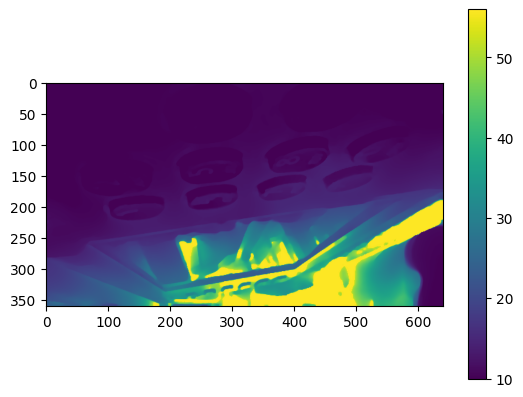

9.943523 55.991276
(33, 360, 640, 3) 11.0 255.0
Pixel size: 1
33 360 640
float32 float32
Depth range: 1 - 300
Dpt result range: 9.943523 - 55.991276


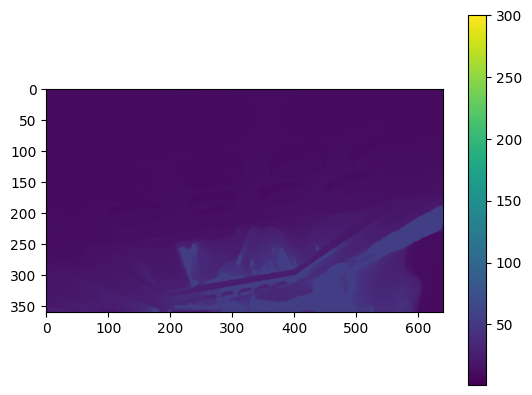

Mean: 18.83607
Median: 11.806222
Standard Deviation: 13.385375


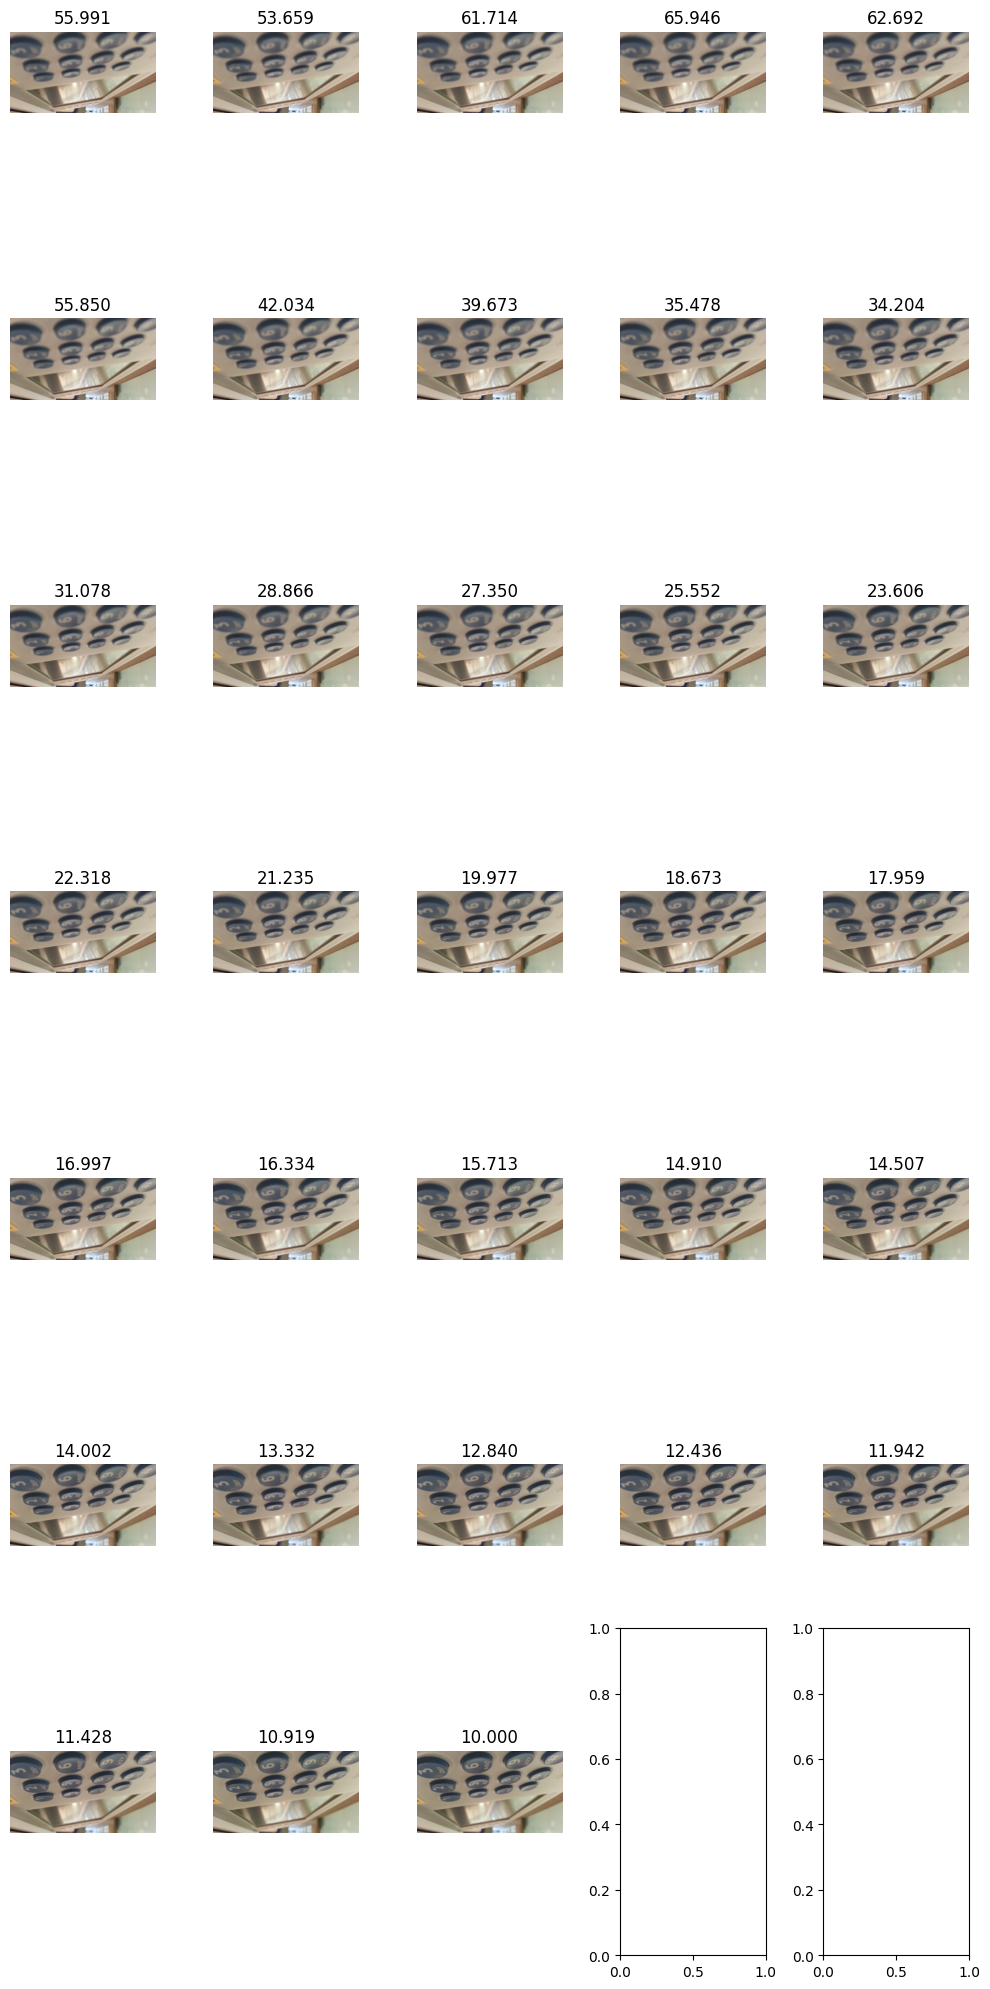

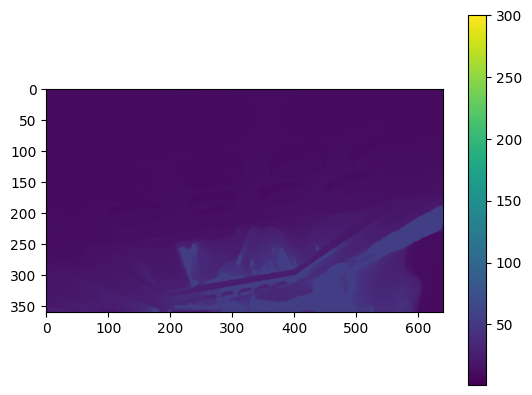

adaptive kernel size set to 21


In [6]:
globals.init_MobileDepth()

IMAGE_RANGE = 255.
example_name = "telephone"
# ["keyboard", "bottles", "fruits", "metals", "plants", "telephone", "window", "largemotion", "smallmotion", "zeromotion", "balls"]:

defocus_stack, dpt_result, scale_mat = utils.load_single_sample_MobileDepth(example_name)

# defocus_stack = np.stack([
#     skimage.transform.resize(img, (img.shape[0] // 2, img.shape[1] // 2), anti_aliasing=True)
#     for img in defocus_stack
# ], axis=0)

defocus_stack *= IMAGE_RANGE 

print(defocus_stack.shape, defocus_stack.min(), defocus_stack.max())
print('Pixel size:', globals.ps)


fs, width, height, _ = defocus_stack.shape
print(fs, width, height)
print(dpt_result.dtype, defocus_stack.dtype)

globals.min_Z = 1#max(0.1, globals.Df.min() - 3)
globals.max_Z = 300#min(max(width, height)*5, globals.Df.max() + 3)
print('Depth range:', globals.min_Z,'-', globals.max_Z)
print('Dpt result range:', dpt_result.min(), '-',dpt_result.max())

plt.imshow(dpt_result, vmin=globals.min_Z, vmax=globals.max_Z)
plt.colorbar()
plt.show()

mean = np.mean(dpt_result)
median = np.median(dpt_result)
std = np.std(dpt_result)

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std)

utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)

# plt.imshow(scale_mat)
# plt.colorbar()
# plt.show()

plt.imshow(dpt_result, vmin=globals.min_Z, vmax=globals.max_Z)
plt.colorbar()
plt.show()

# print(scale_mat.shape)
# print(scale_mat)

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)


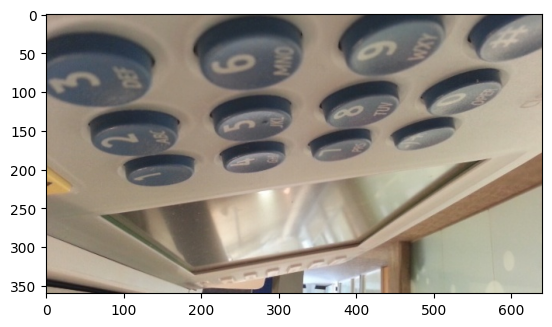

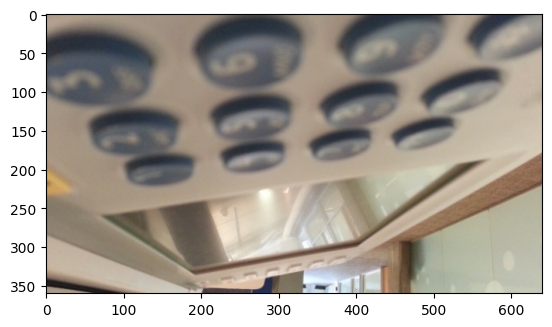

In [7]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05,
                                                     sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

Created experiment folder: /data/holly_jackson/experiments/coord-descent_2025-11-03_23-44-04
Images in range [0-255]


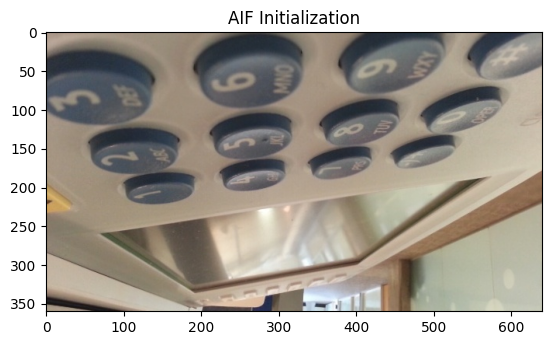

Iteration 0 



Grid search         : 100%|███████████████████| 100/100 [13:00<00:00,  7.80s/it]


GRID SEARCH DURATION 781.1774904727936


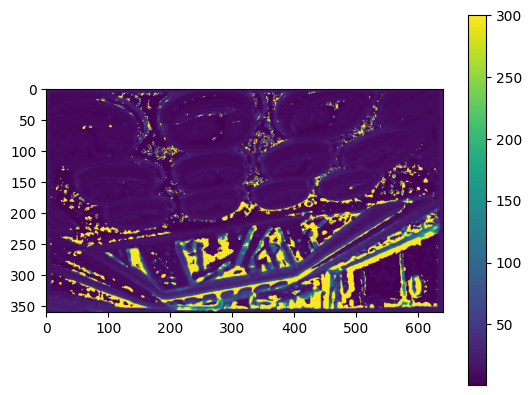


Golden-section search...
...searching for 100 % convergence


In [ ]:
# -------------------
# COORDINATE DESCENT
# -------------------

globals.thresh = 0.5
globals.window_size = 5

dpt, aif, _, _ = coordinate_descent.coordinate_descent(defocus_stack,
        experiment_folder='/data/holly_jackson/experiments',
        show_plots=True, save_plots=False, num_epochs = 1,
        # experiment_name = 'mobile-depth-keyboard-window5-grid',
        # least_squares_first=True, depth_init=depth_init,
        least_squares_first = False, aif_init = aif_init,                                             
        k = 1, aif_method = 'fista',
        finite_differences = False, num_Z = 100, 
        ls_maxiter = 200, ls_maxiter_multiplier = 1.05, 
        min_Z = globals.min_Z, max_Z = globals.max_Z,
        vmin = globals.min_Z, vmax = globals.max_Z, verbose = True,
        windowed_mse = True)


In [ ]:
print('RMS', utils.compute_RMS(dpt, gt_dpt))
print('Rel', utils.compute_Rel(dpt, gt_dpt))
print(utils.compute_accuracy_metrics(dpt, gt_dpt))

utils.plot_compare_greyscale(dpt, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())


# todo: fista check if A @ x is quicker stacked or in loop

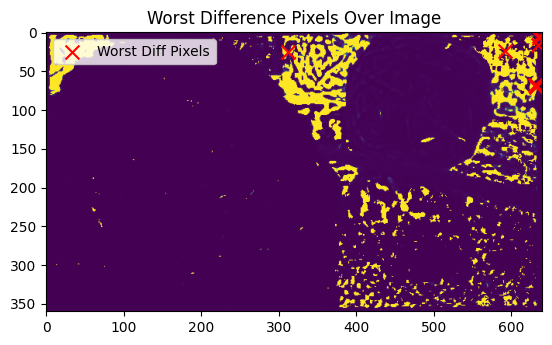

In [16]:
worst_coords = utils.get_worst_diff_pixels(dpt, dpt_result, num_worst_pixels=10, vmin=globals.min_Z, vmax=globals.max_Z)

k = 10  # top-k best (smallest diffs)

diff = np.abs(dpt - dpt_result)
flat = diff.ravel()

# k smallest indices (unsorted), then sort them by value ascending
best_idx = np.argpartition(flat, k)[:k]
best_idx = best_idx[np.argsort(flat[best_idx])]

# 2D coordinates (row, col), sorted by increasing diff
rows, cols = np.unravel_index(best_idx, diff.shape)
best_coords = list(zip(rows, cols))

In [17]:
depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt_k(
    aif, defocus_stack,
    indices = None, min_Z = globals.min_Z, max_Z = globals.max_Z, num_Z = 100, k = 1)

print(k_min_indices.shape)

Grid search         : 100%|███████████████████| 100/100 [08:28<00:00,  5.09s/it]


(360, 640, 1)


In [ ]:
dpt = np.array([[globals.min_Z]], dtype=np.float32)
r = forward_model.computer(dpt, globals.Df)[...,None,None]
# print(r)

print(globals.Df, globals.D, globals.f)
Df_expanded = globals.Df.reshape(1, 1, -1)
CoC = ((globals.D) 
        * (np.abs(dpt[...,None] - Df_expanded) / (dpt[...,None]+1e-8)) 
        * (globals.f / np.abs(Df_expanded - globals.f)))
r = CoC / 2. / globals.ps
print(CoC)
print(r)

In [ ]:
i, j = 100, 100
utils.plot_grid_search_on_pixel(i, j, Z, all_losses,
                                k_min_indices=k_min_indices[i,j])

1 39.252525 -8.514847 -8.524902


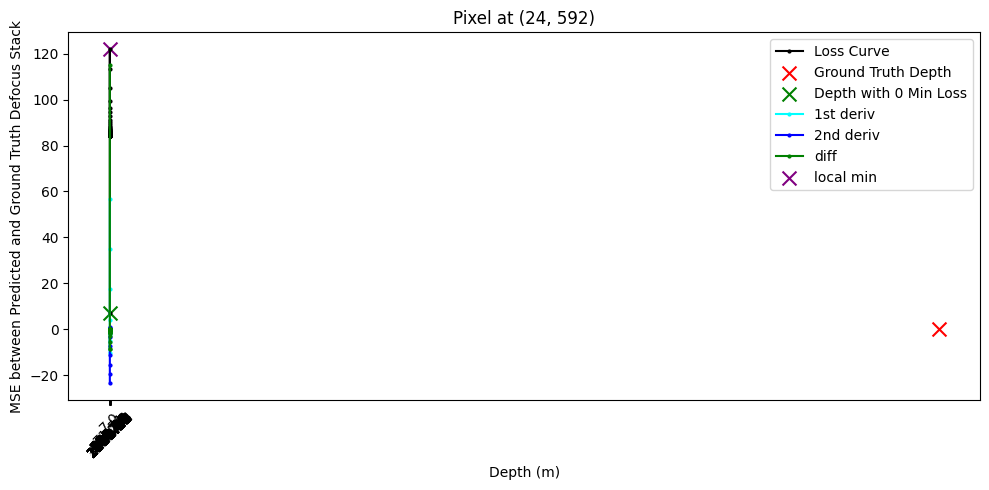

1 39.252525 -0.43042946 0.055130005
2 71.50505 0.055130005 0.04650879
7 232.76767 -0.0075092316 0.0016212463
8 265.0202 0.0016212463 0.0057315826
82 2651.707 -3.0517578e-05 -4.386902e-05


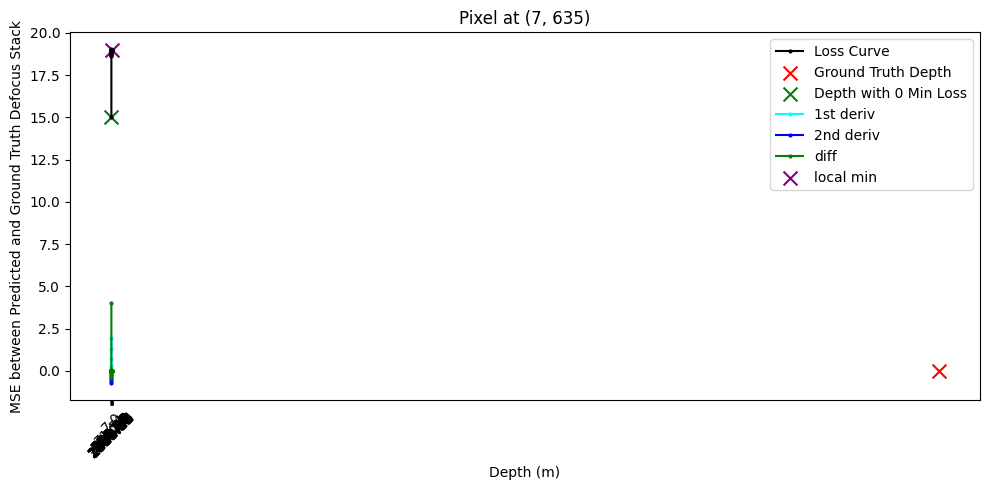

3 103.757576 -0.0050640106 -0.0043444633
5 168.26262 0.0006747246 -0.009446621
6 200.51515 -0.009446621 -0.010829926


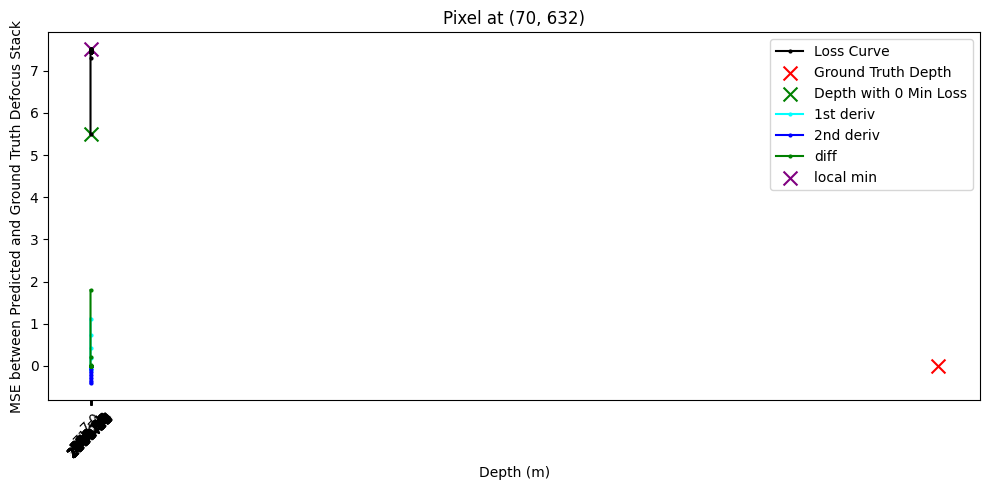

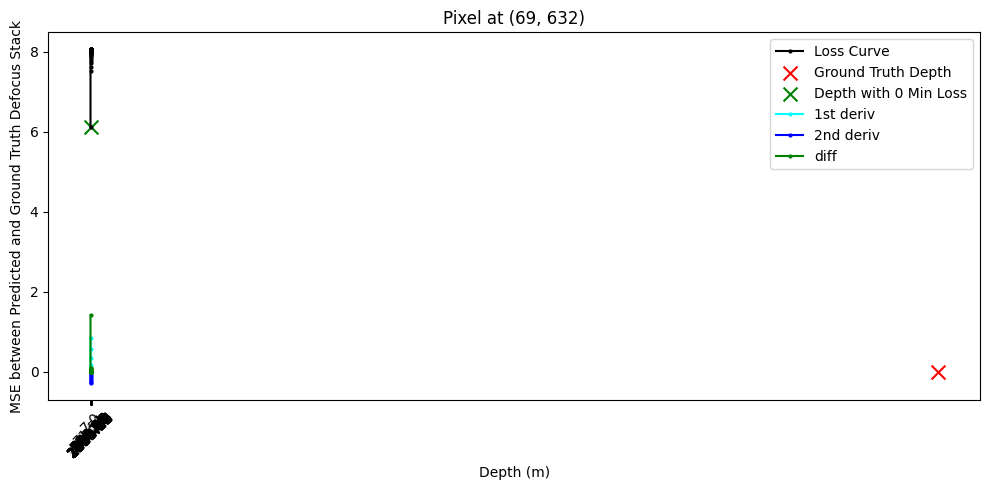

82 2651.707 -6.67572e-05 -6.2942505e-05


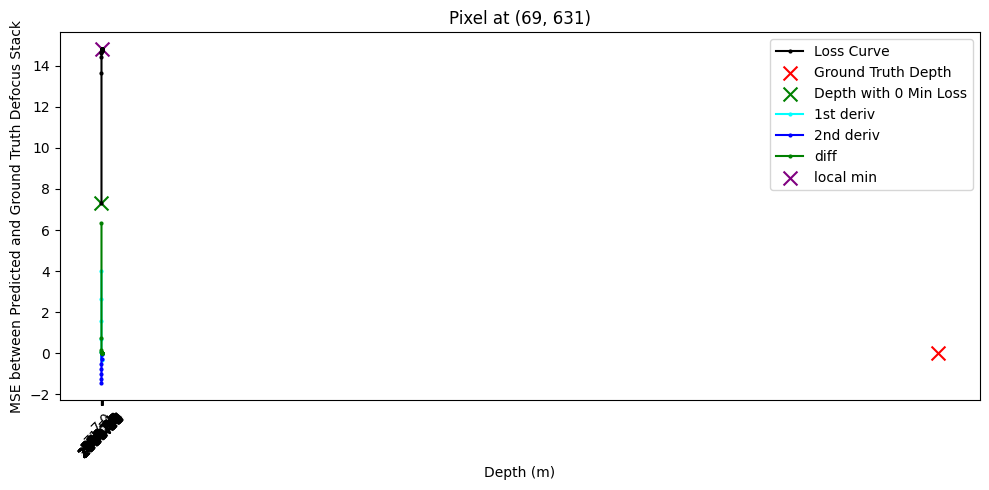

1 39.252525 1.4333553 0.9898033


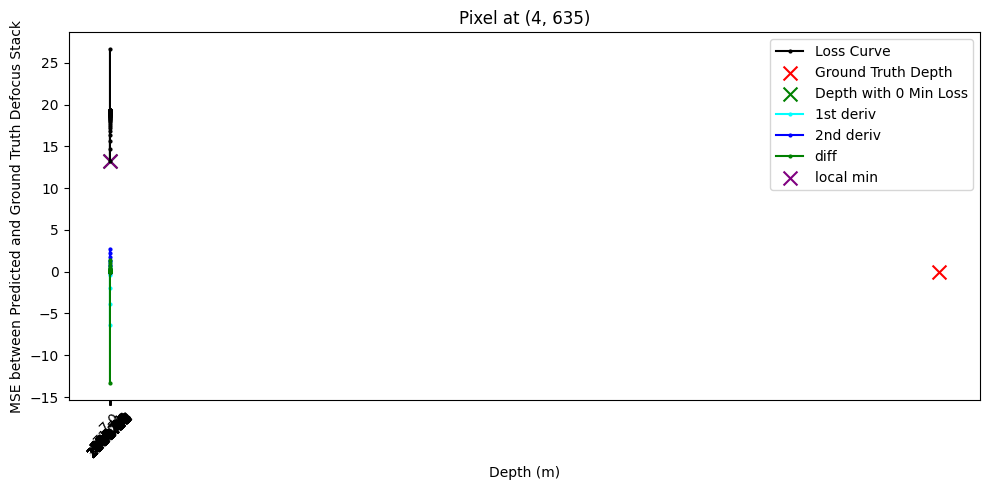

2 71.50505 -0.098155975 -0.09643555


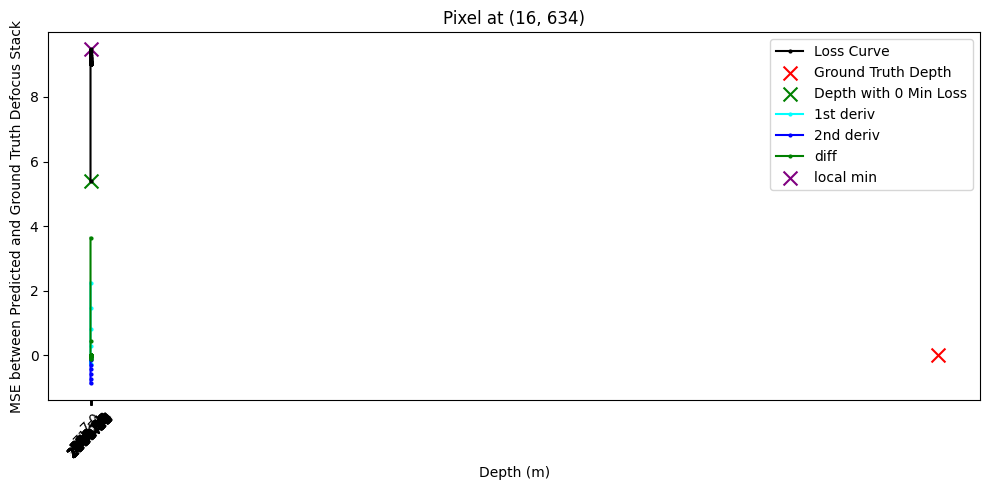

1 39.252525 0.1206584 0.03650236
4 136.0101 -0.0017733574 -0.0066046715
50 1619.6262 6.198883e-06 -2.2411346e-05
51 1651.8788 -2.2411346e-05 -1.1444092e-05
62 2006.6566 1.4305115e-06 6.198883e-06
64 2071.1616 -7.6293945e-06 -1.2874603e-05
66 2135.6667 8.106232e-06 -3.8146973e-06
67 2167.9192 -3.8146973e-06 -3.8146973e-06
70 2264.6768 2.861023e-06 -9.536743e-07
71 2296.9292 -9.536743e-07 -2.3841858e-06
73 2361.4343 7.6293945e-06 -1.001358e-05
74 2393.6868 -1.001358e-05 3.33786e-06
75 2425.9395 3.33786e-06 1.4305115e-06
77 2490.4443 -1.001358e-05 -2.3841858e-06
79 2554.9495 7.1525574e-06 -4.7683716e-07
80 2587.202 -4.7683716e-07 -1.4305115e-05


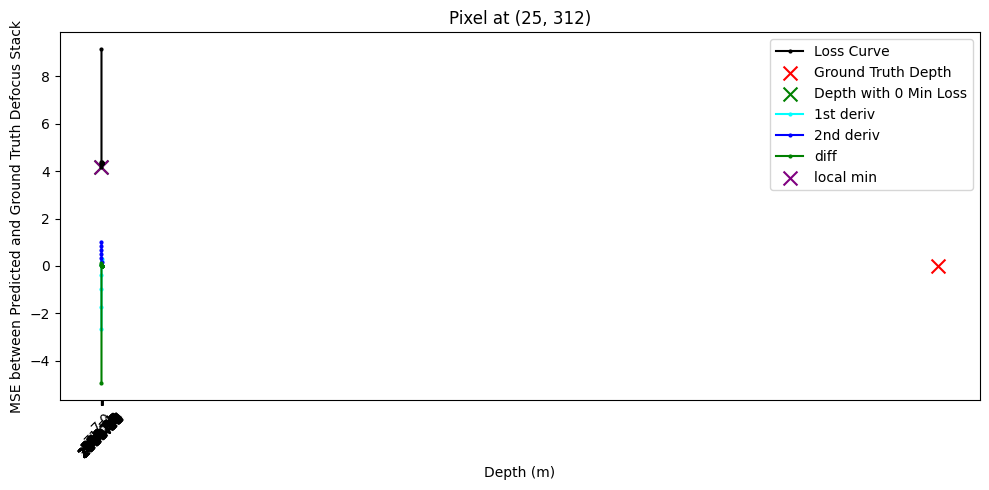

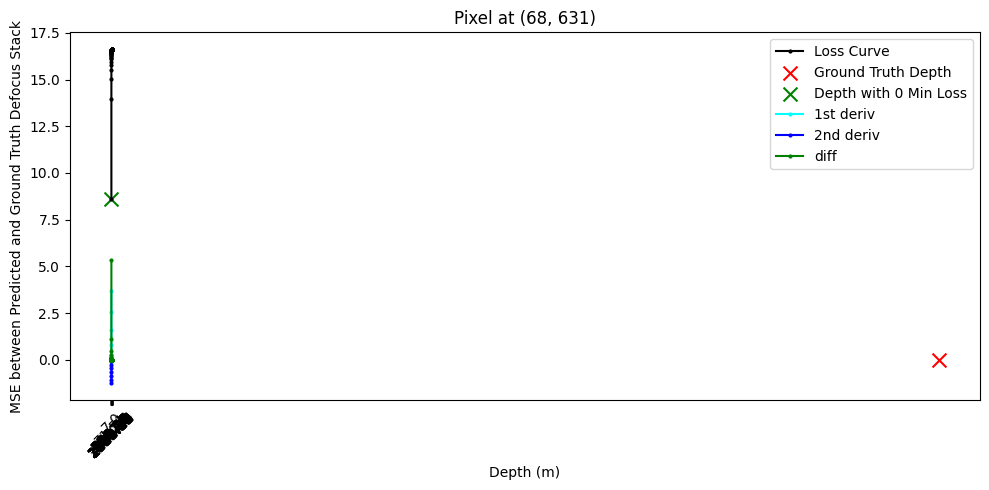

2 71.50505 -0.5642319 -0.41789246


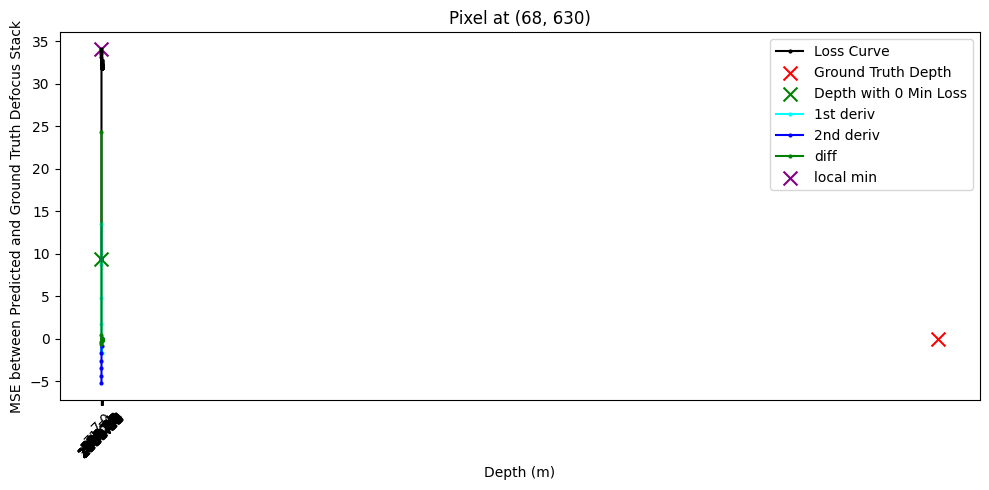

2 71.50505 -1.2381668 -0.7620697


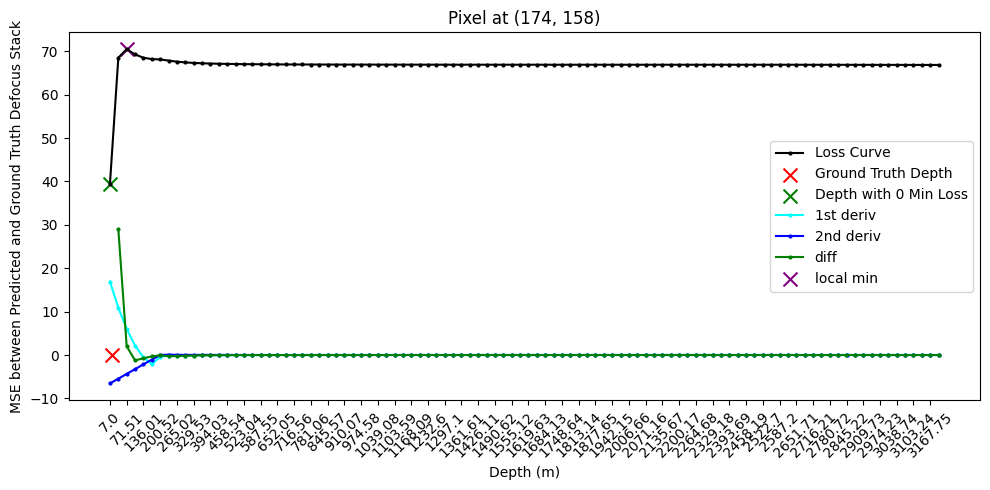

1 39.252525 3.014821 1.5557737


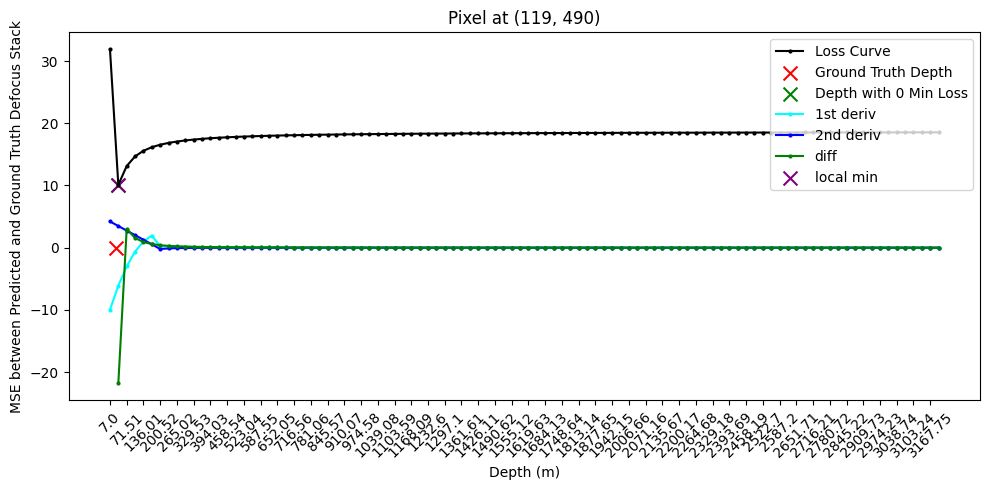

1 39.252525 -0.7529602 -4.293091


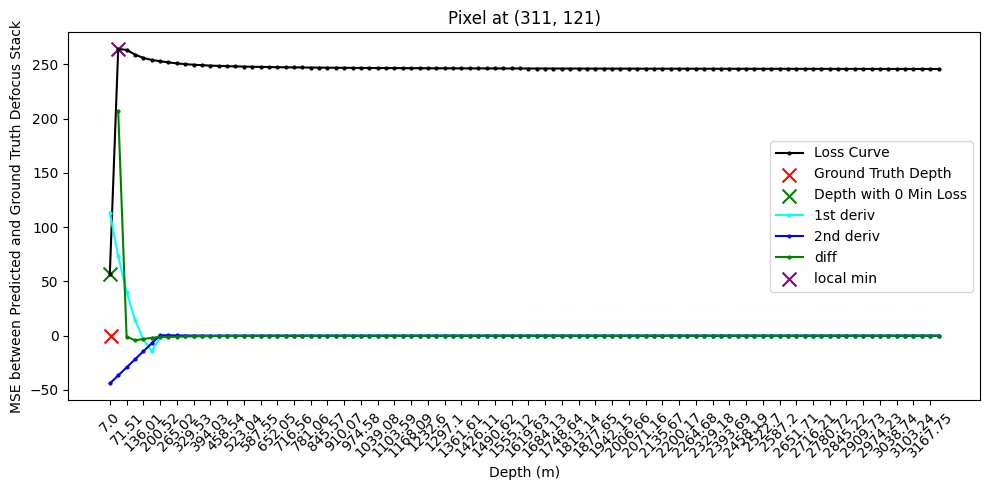

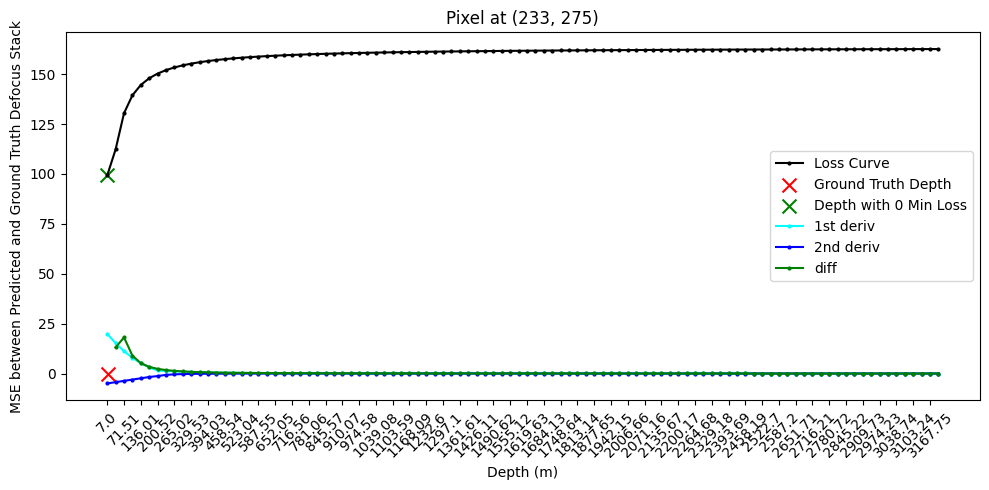

2 71.50505 -3.8310242 -3.3483887


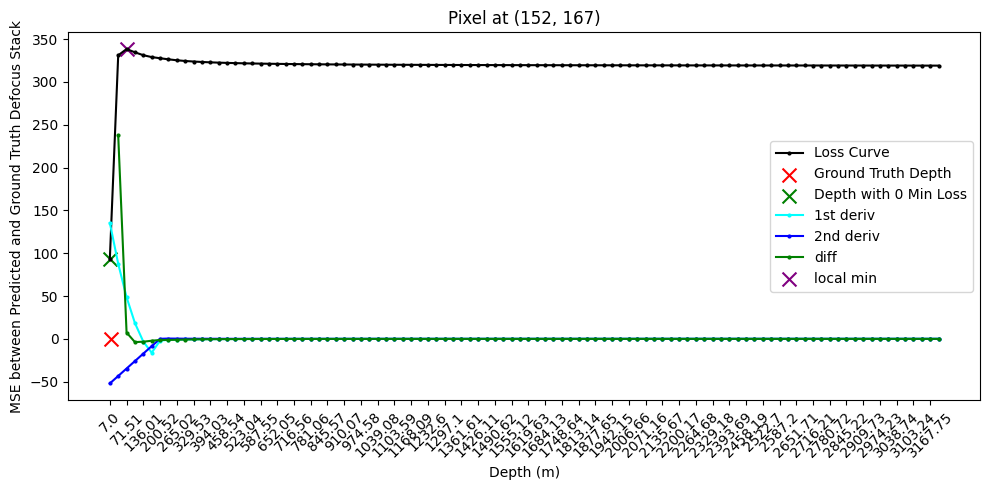

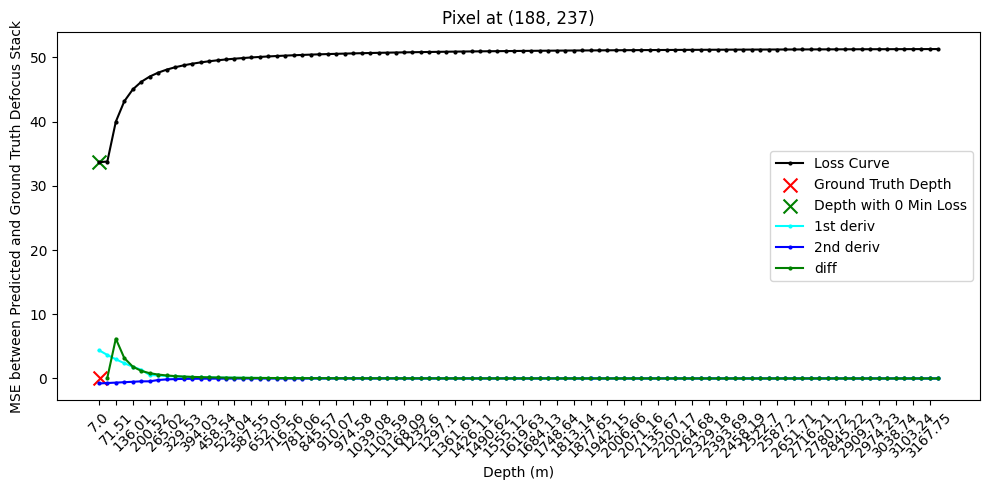

2 71.50505 -0.0049915314 -0.12512207


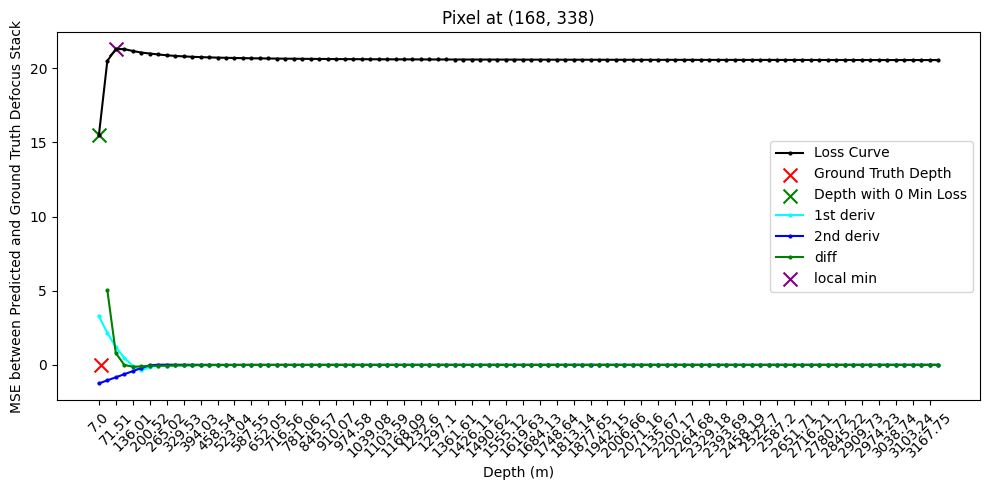

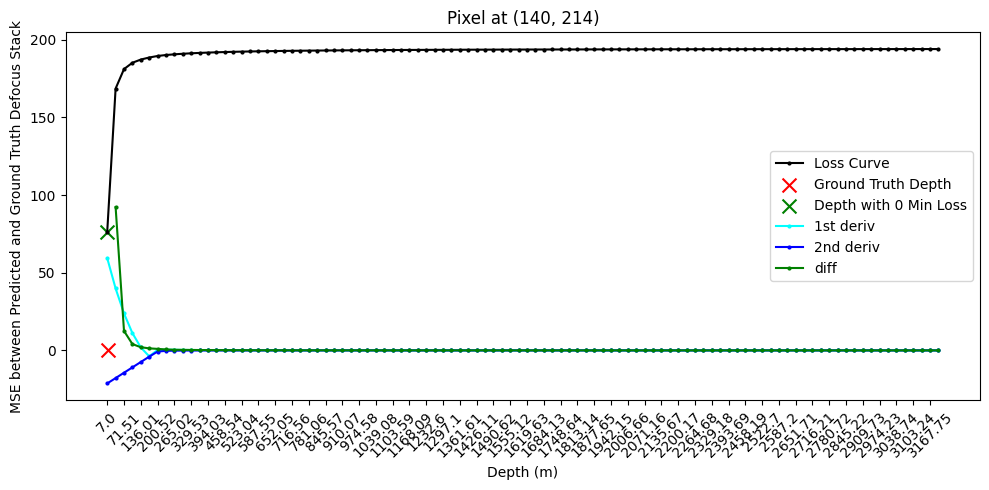

2 71.50505 -1.804596 -1.5112991


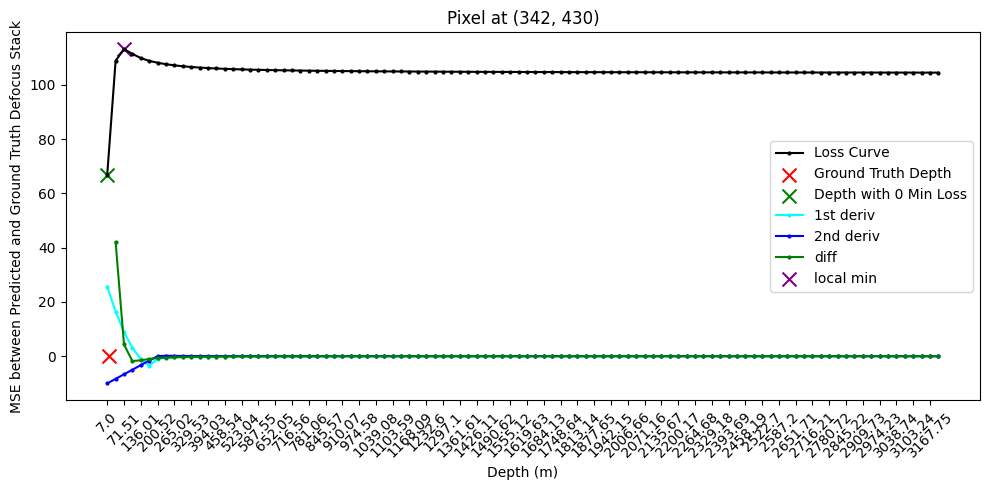

1 39.252525 7.090702 4.3719864


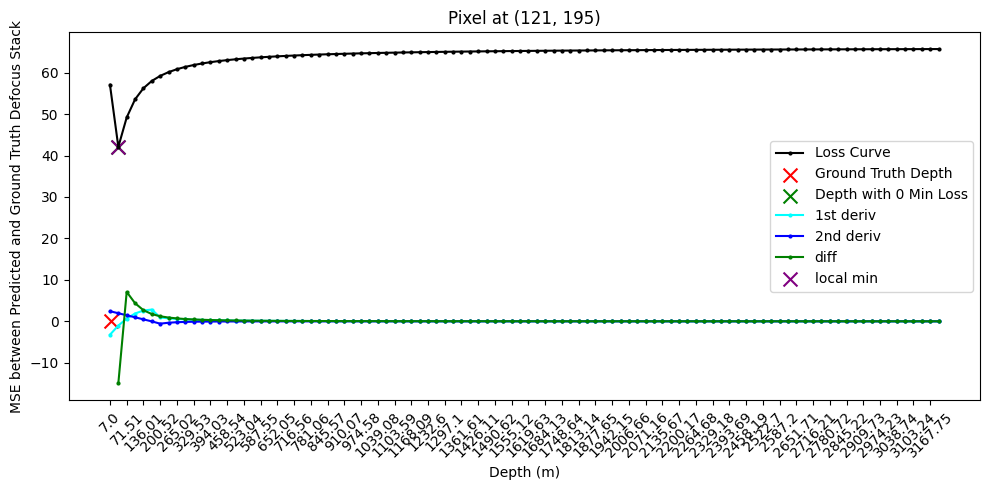

In [21]:
for i, j in worst_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=dpt_result,
                                k_min_indices=k_min_indices[i,j])

for i, j in best_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=dpt_result,
                                k_min_indices=k_min_indices[i,j])
    

In [ ]:
# instead of min loss what if we found area with highest magnitude second derivative 


In [ ]:
def strongest_curvature_region(i, j, all_losses, window=11):
    window = int(window)
    if window < 1:
        raise ValueError("window must be >= 1")
    if window % 2 == 0:
        window += 1
        
    losses = all_losses[i, j]
    d2 = np.gradient(np.gradient(losses))

    kernel = np.ones(window) / window
    avg_d2 = np.convolve(d2, kernel, mode="valid")

    # region with most negative average curvature
    start_valid = (window - 1) // 2
    center_offset = int(np.argmin(avg_d2))
    idx_center_region = start_valid + center_offset
    
    return idx_center_region

for i, j in worst_coords:
    idx_max_point, idx_min_point = strongest_curvature_region(i, j, all_losses, Z)
    print(Z[idx_max_point], Z[idx_min_point])